In [1]:
!pip install tensorflow==2.0.0-beta1

     |████████████████████████████████| 87.9MB 37.3MB/s 
     |████████████████████████████████| 3.1MB 40.0MB/s 
     |████████████████████████████████| 501kB 44.1MB/s 
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.0.0-beta1


In [0]:
def plot_series(time, series, format = "-",
                start = 0, end = None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)
  

def trend(time, slope = 0):
  return slope * time


def seasonal_pattern(season_time):
  """Just an arbitrary pattern, you can change if if you wish"""
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2* np.pi),
                  1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude = 1, phase = 0):
  """Repeats the same pattern at each period"""
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level = 1, seed = None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

In [0]:
time = np.arange(4 * 365 + 1, dtype = "float32")
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.05
noise_level = 5

In [0]:
## Create the series
series = baseline + trend(time, slope) +\
         seasonality(time, period = 365,
                     amplitude = amplitude)

## Update with noise
series += noise(time, noise_level, seed = 42)

In [0]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift = 1,
                           drop_remainder = True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [8]:
dataset = windowed_dataset(x_train, window_size,
                           batch_size, shuffle_buffer_size)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, input_shape = [window_size],
                          activation = "relu"),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss = "mse",
              optimizer = tf.keras.optimizers.SGD(lr = 1e-6, momentum = 0.9))

model.fit(dataset, epochs = 100, verbose = 0)

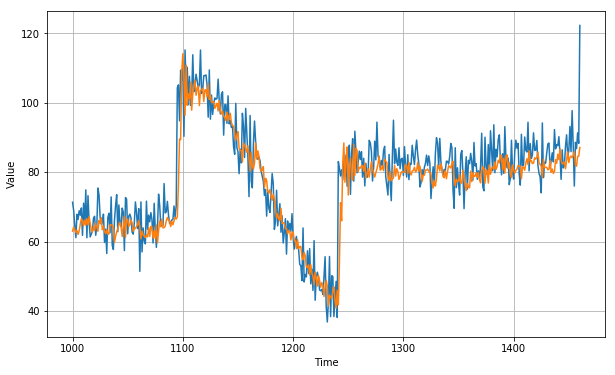

In [9]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
  
forecast = forecast[split_time - window_size : ]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize = (10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [10]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.192884

In [0]:
dataset = windowed_dataset(x_train, window_size, batch_size,
                           shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape = [window_size],
                          activation = "relu"),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch / 20)
)

optimizer = tf.keras.optimizers.SGD(lr = 1e-8, momentum = 0.9)

model.compile(loss = "mse",
              optimizer = optimizer)

history = model.fit(dataset, epochs = 100,
                    callbacks = [lr_schedule],
                    verbose = 0)

[1e-08, 0.001, 0, 300]

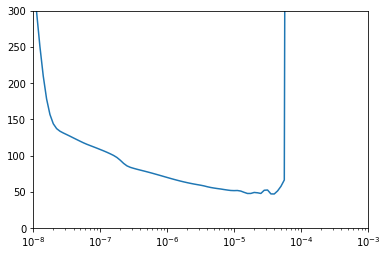

In [12]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [0]:
window_size = 30

dataset = windowed_dataset(x_train, window_size, batch_size,
                           shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation = "relu",
                          input_shape = [window_size]),
    tf.keras.layers.Dense(10, activation = "relu"),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr = 2e-5, momentum = 0.9)

model.compile(loss = "mse",
              optimizer = optimizer)

history = model.fit(dataset, epochs = 500, verbose = 0)

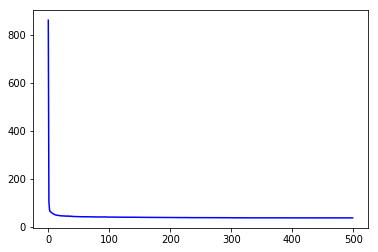

In [14]:
loss = history.history['loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label = 'Training Loss')
plt.show()

[52.25317121682708, 51.14466951901151, 50.352004084636256, 49.61326061524067, 49.29262640648282, 48.72440752245716, 48.216429134250916, 47.91878117433528, 47.47633082203029, 47.16850478575402, 46.73811027290895, 46.421786613071085, 46.39024970457726, 46.80093136030374, 45.986929384211905, 46.576602868935495, 46.09698499699229, 45.849902941516994, 45.10922914878609, 45.65850166242147, 44.98005847341007, 45.646936448087395, 45.47876710793407, 44.558426721317254, 45.63563580463842, 44.941170910707456, 44.213022165200144, 43.9506851392923, 45.14784119596187, 44.33937289051174, 43.79543170732321, 43.71101134388717, 43.56399472030168, 43.515683628357564, 43.454058900813465, 43.373069743520205, 43.27965537002406, 43.37864125438572, 43.09581442764125, 42.963519633185, 42.87517241645105, 42.845972332511984, 42.714658005704585, 42.6644594094188, 42.59662402438134, 42.55085818103908, 42.799193038153895, 42.63448533913524, 42.47819219766204, 42.430266193507876, 42.601787138476816, 42.6122193169348

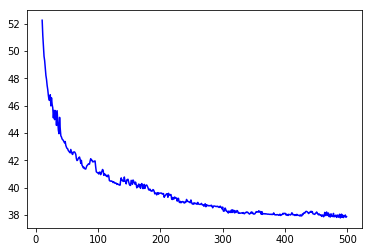

In [15]:
## Plot all but the first 10

loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)

plt.plot(epochs, plot_loss, 'b', label = 'Training Loss')
plt.show()

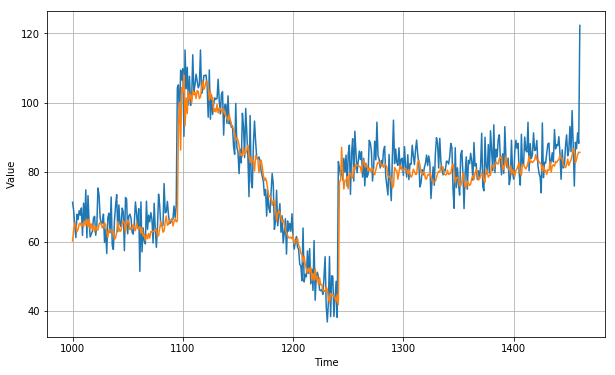

In [16]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time: time + window_size][np.newaxis]))
  
forecast = forecast[split_time - window_size : ]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize = (10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [17]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.961502